In [1]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers

Using TensorFlow backend.
/home/suzychoi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/suzychoi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/suzychoi/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/suzychoi/.local/lib/python3.7/site-packages/tensorflo

https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Using%20Word%20Embeddings%20for%20Sentiment%20Analysis.ipynb

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
# root = Path('../')
# input_path = root / 'input/'
# ouput_path = root / 'output/'
# source_path = root / 'source/'

In [3]:
import nltk
from nltk.corpus import stopwords
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

In [4]:
yelp_review = "./review_data.csv"
reviews= pd.read_csv(yelp_review)
reviews=reviews[reviews.stars!=3]
reviews["labels"]= reviews["stars"].apply(lambda x: 1 if x > 3  else 0)
reviews=reviews.drop("stars",axis=1)

reviews = reviews[["labels","text"]]
reviews.head()
reviews.text = reviews.text.apply(remove_stopwords)


In [5]:
reviews.text[0]

"Great basics. Beans made right. Tortillas typical. But cooks know sauces normal. Don't scared speak English knowing little Spanish makes experience better. If live speak Spanish anyways."

In [6]:
X_train, X_test, y_train, y_test = train_test_split(reviews.text, reviews.labels, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 930651
# Test data samples: 103406


In [7]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [8]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    930651.000000
mean         53.338982
std          49.358198
min           1.000000
25%          22.000000
50%          38.000000
75%          66.000000
max         694.000000
Name: text, dtype: float64

In [9]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

X_train_seq_trunc[10]  # Example of padded sequence

array([6014,  847,    3,   43,   74,  413,  126,   45,  400, 1116,  849,
         38,  564, 2000,   25,  204,   52,  326,  567,  221,  113, 4709,
        250, 6863], dtype=int32)

In [10]:
#encoding
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [11]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [12]:
#validation set
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)
assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (93066, 24)


In [13]:
#Modeling
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 386       
Total params: 80,386
Trainable params: 80,386
Non-trainable params: 0
_________________________________________________________________


In [14]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [15]:
print(emb_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


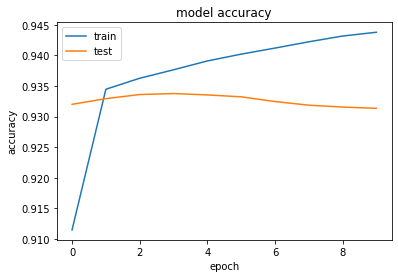

In [16]:
# summarize history for accuracy
plt.plot(emb_history.history['accuracy'])
plt.plot(emb_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


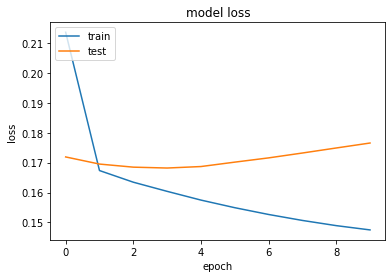

In [17]:
# summarize history for loss
plt.plot(emb_history.history['loss'])
plt.plot(emb_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

103406/103406 [==============================] - 1s 13us/step
/n
Test accuracy of word embeddings model: 92.95%


In [19]:
# from glove import Corpus, Glove

# #Creating a corpus object
# corpus = Corpus() 

# #Training the corpus to generate the co occurence matrix which is used in GloVe
# corpus.fit(lines, window=10)

# glove = Glove(no_components=5, learning_rate=0.05) 
# glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
# glove.add_dictionary(corpus.dictionary)
# glove.save('glove.model')

In [20]:
import os
import itertools

#preparing the embedding layer
GLOVE_DIR='./glove_data/'

emb_dict = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(emb_dict))

Found 400001 word vectors.


In [21]:
# emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

# for w, i in tk.word_index.items():
#     # The word_index contains a token for all words of the training data so we need to limit that
#     if i < NB_WORDS:
#         vect = emb_dict.get(w)
#         # Check if the word from the training data occurs in the GloVe word embeddings
#         # Otherwise the vector is kept with only zeros
#         if vect is not None:
#             emb_matrix[i] = vect
#     else:
#         break

In [22]:
# glove_model = models.Sequential()
# glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
# glove_model.add(layers.Flatten())
# glove_model.add(layers.Dense(2, activation='softmax'))
# glove_model.summary()

